## Краткое описание проекта


<b>Цель проекта</b> - провести стартовый анализ сектора общественного питания в Москве по имеющимся открытым данным.

<b>Описание данных:</b>
Для анализа есть открытые данные о заведениях общественного питания в Москве.
    
<b>Задачи:</b>
 - чтение и первичный анализ данных;
 - изучить данные заведений в разбивке по их видам;
 - найти отличия между сетевыми и не сетевыми заведениями;
 - изучить данные в разбивке по улицам и районам Москвы.

<b>Таблица rest_data:</b>
 - id — идентификатор объекта;
 - object_name — название объекта общественного питания;
 - chain — сетевой ресторан;
 - object_type — тип объекта общественного питания;
 - address — адрес;
 - number — количество посадочных мест



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from collections import Counter
from io import BytesIO
import requests
import folium
import json

## Чтение данных

In [2]:
rest_data = pd.read_csv('rest_data.csv')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


В первых строках и названиях столбцов очевидных ошибок нет.  
Необходимо привести столбцы address и object_name к нижнему регистру.

In [3]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['address'] = rest_data['address'].str.lower()
rest_data.head(2)

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35


In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропущенных данных нет, типы данных корректны.  
Проверим наличие очевидно не корректных данных:

In [5]:
for column in rest_data.columns:
    print(column)
    if rest_data[column].dtype == 'object':
        print(rest_data[column].unique())
    else:
        print('min', rest_data[column].min())
        print('max', rest_data[column].max())
    print()

id
min 838
max 223439

object_name
['сметана' 'родник' 'кафе «академия»' ... 'бар мята lounge'
 'мята lounge октябрьская' 'кальянная «мята lounge»']

chain
['нет' 'да']

object_type
['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']

address
['город москва, улица егора абакумова, дом 9'
 'город москва, улица талалихина, дом 2/1, корпус 1'
 'город москва, абельмановская улица, дом 6' ...
 'город москва, салтыковская улица, дом 7г'
 'город москва, осенний бульвар, дом 9'
 'город москва, улица новый арбат, дом 13']

number
min 0
max 1700



В столбцах object_name и address слишком много уникальных значений, поэтому их рассмотрим отдельно, когда это понадобится для дальнейшего анализа.  

Есть слишком большие величины в количестве мест, рассмотрим их распределение более детально:

Text(0, 0.5, 'Заведения')

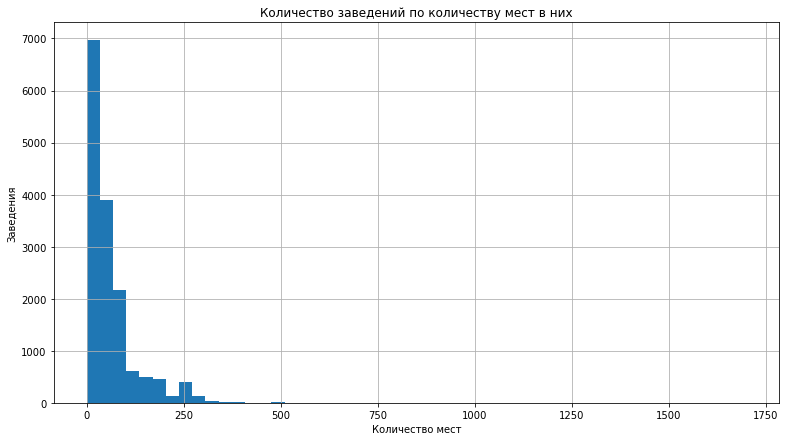

In [6]:
plt.figure(figsize=(13, 7))
plt.title('Количество заведений по количеству мест в них')
ax = rest_data['number'].hist(bins = 50)
ax.set_xlabel('Количество мест')
ax.set_ylabel('Заведения')

In [7]:
np.percentile(rest_data['number'], [95, 99])

array([214., 300.])

На графике видно, что в данных есть выбросы: всего 1% от всех заведений имеет число мест больше 300 и только 5% - выше 214 мест. Чтобы в дальнейшем подобные выбросы не искажали результаы будем рассматривать только заведение с количеством мест до 214.

In [8]:
rest_data = rest_data[rest_data['number'] <= 214]

Также необходимо проверить заведения с количеством мест равным нулю. Отдельно необходимо будет рассмотреть названия заведений (если они понадобятся в ходе анализа).

In [9]:
rest_data[rest_data['number'] == 0]['object_type'].unique()

array(['закусочная', 'предприятие быстрого обслуживания', 'столовая',
       'кафетерий', 'кафе', 'магазин (отдел кулинарии)', 'буфет', 'бар',
       'ресторан'], dtype=object)

0 мест бывает у всех типов заведений.

Рассмотрим более детально на примере ресторанов:

In [10]:
rest_data[(rest_data['number'] == 0) &(rest_data['object_type'] == 'ресторан')]

,id,object_name,chain,object_type,address,number
1873,79718,макдоналдс,да,ресторан,"город москва, поселение московский, деревня го...",0
4490,152298,фудмаркет. яшечкина,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4491,152299,фудмаркет. грачева,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4492,152305,фудмаркет. шапиро,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4493,152307,фудмаркет. салпагарова,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4501,152255,фудмаркет.швыдкой,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4502,152222,фудмаркет.паритова,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4503,152224,фудмаркет. рогачикова,нет,ресторан,"город москва, улица новый арбат, дом 21",0
4504,152216,фудмаркет. галичкин,нет,ресторан,"город москва, улица новый арбат, дом 21",0
6113,27193,максимальный ресторан,нет,ресторан,"город москва, профсоюзная улица, дом 61а",0


Видим, что многие из них находятся в фудкортах, также рестораны без фудкорта в названии часто находятся по одниому и тому же адресу. Вероятнее всего, у этих заведений официально нет собственных мест, т.к. они используют общие места фудкорта. Поэтому не будем менять или удалять строки с нулевым количеством мест.


Проверим наличие дубликатов:

In [11]:
sum(rest_data.duplicated())

0

Дубликатов нет.

<b>Вывод:</b> 
 - привели записи адресов и названий заведений к нижнему регистру.
 - убрали из данных все заведения, где количество мест превышает 214, т.к. таких заведений всего 5% и они могут исказить результат.
 - Вероятнее всего, нулевое количество мест - не ошибка: у закусочных мест действительно может не быть, также их может не быть у заведений, где есть общие места с другими заведениями.
 - Дублирующиеся данные или очевидно не корректные данные отсутствовали.

## Анализ данных

### Виды объектов общественного питания

Рассмотрим распределение объектов общественного питания по типу:

In [12]:
object_type_group = rest_data.groupby('object_type', as_index=False).agg({'id':'count'})
object_type_group.columns = ['object_type', 'amount']
object_type_group = object_type_group.sort_values(by = 'amount', ascending = False)
object_type_group

,object_type,amount
3,кафе,6058
7,ресторан,2139
8,столовая,2040
6,предприятие быстрого обслуживания,1914
0,бар,849
1,буфет,568
4,кафетерий,398
2,закусочная,359
5,магазин (отдел кулинарии),273


Построим график:

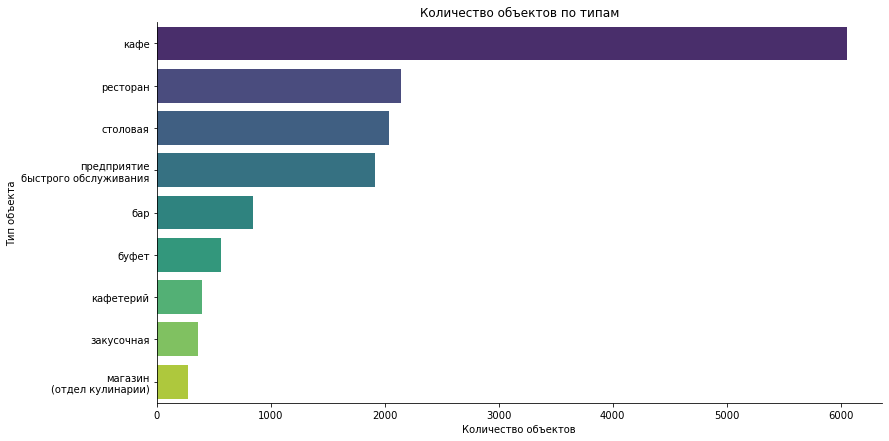

In [13]:
plt.figure(figsize=(13, 7))
plt.title('Количество объектов по типам')
ax = sns.barplot(data = object_type_group, x = 'amount', y = 'object_type', palette="viridis")
ax.set_xlabel('Количество объектов')
ax.set_ylabel('Тип объекта')
ax.set_yticklabels(['кафе', 'ресторан', 'столовая',
       'предприятие\nбыстрого обслуживания', 'бар', 'буфет', 'кафетерий',
       'закусочная', 'магазин\n(отдел кулинарии)']
)
sns.despine() 

<b>Вывод: </b>наибольшую долю всех заведений занимают кафе, их суммарное число выше двух следующих за ними категорий. На 2-ом и 3-ем местах рестораны и столовые соответственно. Меньше всего закусочных и отделов кулинарии в магазинах.

### Число мест по типам заведения

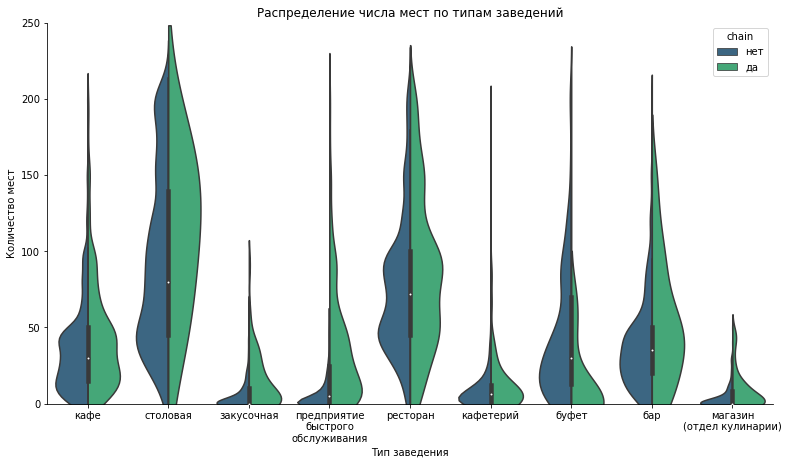

In [14]:
plt.figure(figsize=(13, 7))
plt.title('Распределение числа мест по типам заведений')
ax = sns.violinplot(
    x = 'object_type',
    y = 'number', 
    hue = 'chain',
    split = True,
    scale = 'width',
    data = rest_data, 
    palette = "viridis"
)
ax.set_xticklabels(['кафе', 'столовая', 'закусочная',
       'предприятие\nбыстрого\nобслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин\n(отдел кулинарии)'])
ax.set_ylim(-0, 250)
ax.set_xlabel('Тип заведения')
ax.set_ylabel('Количество мест')
sns.despine()

In [15]:
rest_data.groupby('object_type')['number'].describe().sort_values(by = '50%', ascending = False)\
.style.format('{:.0f}')

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
столовая,2040,94,57,0,45,80,140,214
ресторан,2139,79,46,0,45,72,100,214
бар,849,40,31,0,20,35,50,200
буфет,568,45,44,0,13,30,70,210
кафе,6058,38,32,0,15,30,50,202
кафетерий,398,9,15,0,0,6,12,200
предприятие быстрого обслуживания,1914,19,31,0,0,5,25,210
закусочная,359,7,13,0,0,0,10,91
магазин (отдел кулинарии),273,6,10,0,0,0,8,50


<b>Выводы: </b>
 - В среднем количество мест в столовых и ресторанах существенно выше, чем в остальных типах заведений. При этом, количество мест в столовых распределено равномерней, чем остальных, поэтому доля заведений с количеством мест выше 150 немного ниже 25%.
 - Закусочные, кафетерии и отделы кулинарии в магазинах стандартно имеют мест меньше остальных.
 - У закусочных, предприятий быстрого питания и отделов кулинарии сетевые заведения чаще имеют больше мест, по сравнению с не сетевыми.

### Соотношение сетевых и не сетевых заведений

Рассмотрим соотношение количества сетевых и не сетевых заведений.

In [16]:
chain_group = rest_data.groupby('chain', as_index=False).agg({'id':'count'})
chain_group = chain_group.sort_values(by = 'id', ascending = False)
chain_group['share'] = chain_group['id'] / sum(chain_group['id'])
chain_group.columns = ['chain', 'amount', 'share']
chain_group.style.format({'share':'{:.2%}'})

,chain,amount,share
1,нет,11693,80.10%
0,да,2905,19.90%


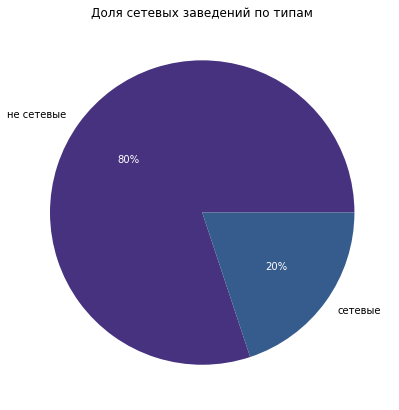

In [17]:
plt.figure(figsize=(7, 7))
data = chain_group['amount']
labels = ['не сетевые', 'сетевые']
palette_color = sns.color_palette("viridis")
ax, _, autotexts = plt.pie(data,
             labels = labels,
             colors = palette_color,
             autopct='%.0f%%',
             startangle = 0
       )
plt.title('Доля сетевых заведений по типам')
for autotext in autotexts:
    autotext.set_color('white')
plt.show()

<b>Вывод:</b> Основная масса заведений(около 80%) не относятся к сетевым.

### Сетевое распространение видов объектов общественного питания

Вычислим для каждого из видов заведений общественного питания долю сетевых заведений:

In [18]:
chain_type_group = rest_data.groupby(['object_type', 'chain'], as_index = False).agg({'id':'count'})

object_type_group['chain_share'] = object_type_group.apply(
    lambda x: max(
        chain_type_group.loc[
        (chain_type_group['object_type'] == x['object_type']) &
        (chain_type_group['chain'] == 'да'),
        'id'
    ]) / x['amount'],
    axis = 1
)

object_type_group = object_type_group.sort_values('chain_share', ascending = False)
object_type_group.style.format({'chain_share':'{:.2%}'})

,object_type,amount,chain_share
6,предприятие быстрого обслуживания,1914,40.86%
5,магазин (отдел кулинарии),273,28.57%
7,ресторан,2139,23.70%
3,кафе,6058,22.76%
2,закусочная,359,15.60%
4,кафетерий,398,13.07%
0,бар,849,4.36%
1,буфет,568,1.94%
8,столовая,2040,0.15%


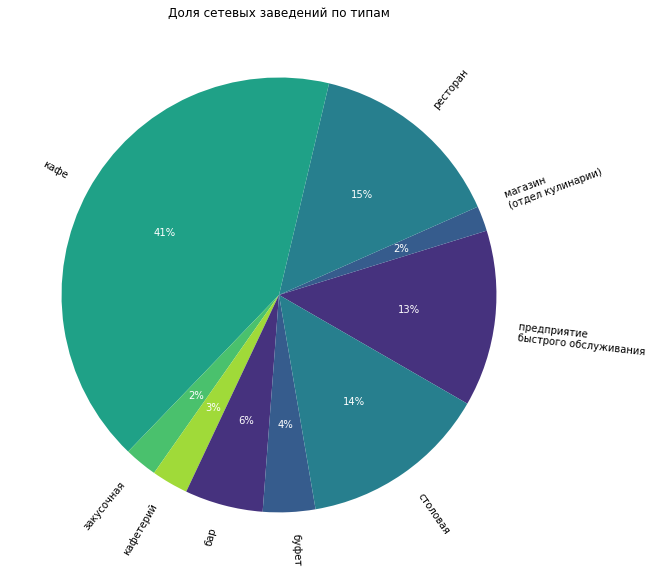

In [19]:
plt.figure(figsize=(13, 10))
data = object_type_group['amount']
labels = ['предприятие \nбыстрого обслуживания', 'магазин \n(отдел кулинарии)',
       'ресторан', 'кафе', 'закусочная', 'кафетерий', 'бар', 'буфет',
       'столовая']
palette_color = sns.color_palette("viridis")
ax, _, autotexsts = plt.pie(data,
             labels = labels,
             colors = palette_color,
             autopct='%.0f%%',
             labeldistance=1.1,
             rotatelabels=True,
             startangle = 330
       )
for autotext in autotexsts:
    autotext.set_color('white')
plt.title('Доля сетевых заведений по типам')
plt.show()

<b>Вывод: </b>максимальная доля сетевых заведений в предприятиях быстрого обслуживания (41.13%) и отделах кулинарии магазинов (28.57%). Реже всего сетевую к сетям принадлежат столовые, буфеты и бары.

### Число мест в сетевых заведения

In [20]:
chain_rest = rest_data[rest_data['chain'] == "да"].groupby('object_name', as_index = False).agg(
    {
        'id':'count',
        'number':'median'
    }
)
chain_rest.columns = ['object_name', 'amount', 'median_seats']
chain_rest.sample(5)

,object_name,amount,median_seats
419,примавера,3,50.0
230,кафе «сабвей» старбакс,2,17.5
310,кулинарная лавка братьев караваевых,16,31.5
216,кафе «кружка»,3,98.0
508,тамаси суши,1,8.0


<Figure size 936x504 with 0 Axes>

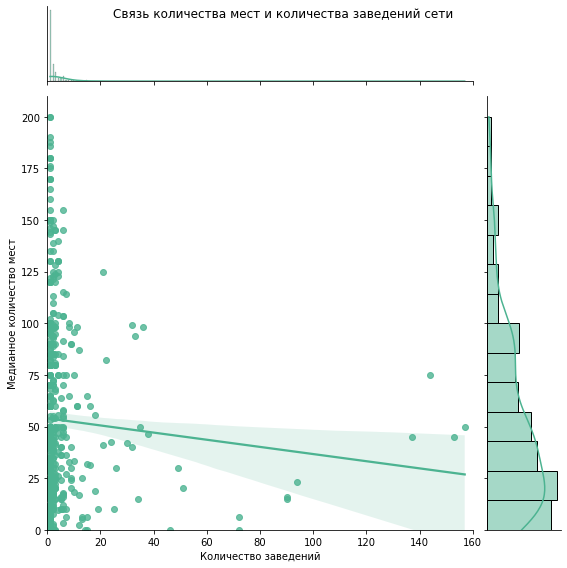

In [21]:
plt.figure(figsize=(13, 7))
ax = sns.jointplot(
    x='amount', 
    y='median_seats',
    data=chain_rest,
    kind='reg',
    color='#4CB391',
    ylim = (0, 210),
    xlim = (0, 160),
    height = 8
)
ax.fig.suptitle('Связь количества мест и количества заведений сети')
ax.ax_joint.set_xlabel('Количество заведений')
ax.ax_joint.set_ylabel('Медианное количество мест')
sns.despine()

Видим что есть определенная связь: крупные сети в среднем имеют около 50 мест, в то время как среди малых сетей встречаются высокие значения(около 350 мест). Есть большое количество сетей с одним заведением, что может объясняться ошибкой или наличием сетевых заведений в других городах. Чтобы убрать влияние таких не стандартных сетей, проанализируем данные без них.

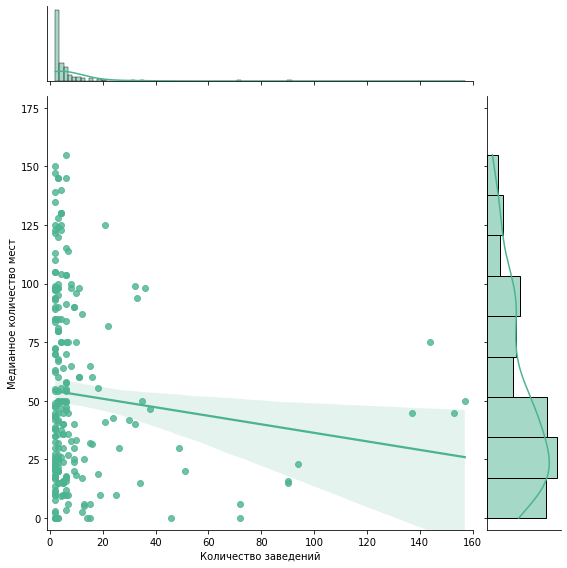

In [22]:
chain_rest = chain_rest[chain_rest['amount'] > 1]

ax = sns.jointplot(
    x='amount', 
    y='median_seats',
    data=chain_rest,
    kind='reg',
    color='#4CB391',
    ylim = (-5, 180),
    xlim = (-1, 160),
    height = 8
)
#ax.fig.suptitle('Связь количества мест и количества заведений сети\nбез сетей с одним заведением')
ax.ax_joint.set_xlabel('Количество заведений')
ax.ax_joint.set_ylabel('Медианное количество мест')
sns.despine() 

Результаты предыдущего графика, фактически, дублируются. Проверим полученные данные с помощью коэффициента корреляции:

In [23]:
chain_rest.corr().loc['median_seats', 'amount']

-0.10478403721002359

Коэффициент корреляции отрицательный, но слабый, поэтому можем считать, что явной связи между количеством заведений и средним количеством мест в них нет.

<b>Вывод: </b>

 - Среди сетей существенно чаще встречаются сети с небольшим числом заведений, количество мест в таких сетях в основном находится в диапазоне от 0 до 100.
 - У крупных сетей среднее количество мест обычно не больше 100. Но сетей с количеством заведений больше 20 не много, и их количество мест находится в наиболее вероятном диапозоне, в котором находится и большинство заведений малых сетей.

### Улицы


Проанализируем улицы по количеству заведений на них.

 - Посмотрим данные топ 10 улиц по количеству заведений на них;
 - Изучим районы, в которых находятся наиболее популярные улицы;
 - Изучим районы, в которых находятся улицы с 1 заведением;


Посмотрим все уникальные слова в названиях улиц и частоту их встречаемости, чтобы найти слова-маячки, по которым мы сможем выделить только названия улиц.

In [24]:
address_list = []
for i in rest_data['address'].str.replace(',', '').str.split(' '):
    address_list.extend(i)

print(Counter(address_list))

Counter({'город': 14926, 'москва': 14530, 'дом': 14088, 'улица': 8597, 'строение': 4041, '1': 3905, 'корпус': 2577, '2': 1902, 'проспект': 1428, 'шоссе': 1260, '3': 1010, '4': 799, 'проезд': 735, 'бульвар': 715, 'переулок': 714, '5': 685, '6': 525, 'большая': 505, '7': 473, '8': 467, '10': 444, 'поселение': 411, '12': 401, '9': 382, 'площадь': 377, 'набережная': 368, '11': 318, 'владение': 300, '15': 291, '13': 291, 'вал': 290, '16': 267, '14': 265, '26': 256, '17': 247, '18': 241, '20': 227, 'зеленоград': 227, '19': 226, '21': 220, 'мира': 197, '22': 195, '27': 188, 'профсоюзная': 179, 'ленинградский': 170, 'арбат': 162, '24': 160, 'пресненская': 160, 'варшавское': 157, '25': 152, 'километр': 149, '1-я': 143, '32': 142, 'ленинский': 142, 'маршала': 139, 'сосенское': 139, '23': 135, 'большой': 135, 'московский': 134, 'вернадского': 128, '33': 125, '29': 122, 'деревня': 120, 'посёлок': 119, '1-й': 117, '1а': 115, 'малая': 114, 'кутузовский': 111, '28': 110, '36': 110, 'каширское': 108, 

Среди наиболее популярных слов можем выделить аналоги улиц: переулок, бульвар, площадь, набережная, шосссе, проспект, улица.

In [25]:
def find_street(string):
    address = string.split(',')
    for i in address:
        if any(
            substr in i 
            for substr in 
            ['переулок', 'бульвар', 'площадь', 'набережная', 'шоссе', 'проспект', 'улица', 'проезд', 'аллея']
        ):
            return i[1:]
    return 'w/o street'

rest_data['street'] = rest_data['address'].apply(find_street)
rest_data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


Рассмотрим адреса, для которых не нашлось улицы.

In [26]:
rest_data.loc[rest_data['street'] == 'w/o street', 'address']

394               город москва, 2-й квартал капотня, дом 1
1044               город москва, 9-я северная линия, дом 1
1405            город москва, город зеленоград, корпус 401
1406            город москва, город зеленоград, корпус 435
1407            город москва, город зеленоград, корпус 436
                               ...                        
14997    город москва, поселение десеновское, деревня в...
14998    город москва, поселение десеновское, деревня в...
15015    поселение "мосрентген", деревня дудкино, владе...
15184          город москва, город зеленоград, корпус 1627
15274    город москва, микрорайон северное чертаново, д...
Name: address, Length: 400, dtype: object

Остались только адреса, которые охватывают кварталы, городки, поселения, деревни и т.д. их мы конкретизировать не будем и в дальнейшем не будем учитывать эти адреса в анализе.

#### Топ 10 улиц

Найдем топ 10 улиц по количеству заведений на них:

In [27]:
streets = rest_data[rest_data['street'] != 'w/o street']\
.groupby('street', as_index = False).agg({'id':'count'}).sort_values(by='id', ascending=False)
streets.columns = ['street', 'amount']
streets.head(10)

,street,amount
1069,проспект мира,197
1073,профсоюзная улица,179
689,ленинградский проспект,168
1026,пресненская набережная,160
399,варшавское шоссе,156
692,ленинский проспект,141
1065,проспект вернадского,128
679,кутузовский проспект,111
602,каширское шоссе,108
1804,ходынский бульвар,101


Построим график:

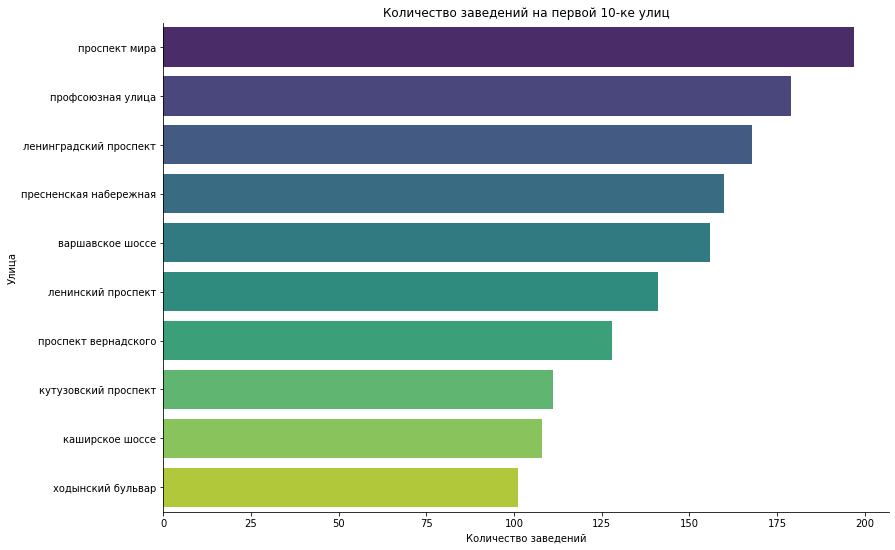

In [28]:
plt.figure(figsize=(13, 9))
plt.title('Количество заведений на первой 10-ке улиц')
ax = sns.barplot(data = streets.head(10), x = 'amount', y = 'street', palette="viridis")
ax.set_xlabel('Количество заведений')
ax.set_ylabel('Улица')
sns.despine()

Для определения районов, к которым относятся улицы, воспользуемся внешним файлом.

In [29]:
spreadsheet_id = '1WPYyWbE6p9H3kA0jti_rmHNzRvvuxgQPyWkTPW11dRE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
districts = pd.read_csv(BytesIO(r.content))
districts.head(2)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район


In [30]:
districts['streetname'] = districts['streetname'].str.lower()

streets = streets.merge(districts, how = 'left', left_on = 'street', right_on = 'streetname')
streets = streets.drop(columns = ['streetname'], axis=1)
streets.head(20)

,street,amount,areaid,okrug,area
0,проспект мира,197,70.0,СВАО,Алексеевский район
1,проспект мира,197,86.0,СВАО,Ярославский Район
2,проспект мира,197,78.0,СВАО,Район Марьина роща
3,проспект мира,197,79.0,СВАО,Останкинский район
4,проспект мира,197,81.0,СВАО,Район Ростокино
5,проспект мира,197,82.0,СВАО,Район Свиблово
6,проспект мира,197,16.0,ЦАО,Мещанский район
7,профсоюзная улица,179,123.0,ЮЗАО,Академический район
8,профсоюзная улица,179,132.0,ЮЗАО,Район Черемушки
9,профсоюзная улица,179,134.0,ЮЗАО,Район Ясенево


Проверим наличие улиц, для которых не нашелся район:

In [31]:
streets[streets['area'].isna()]

,street,amount,areaid,okrug,area
122,калужское шоссе,53,NaN,NaN,NaN
170,улица мичуринский проспект,37,NaN,NaN,NaN
274,улица александры монаховой,24,NaN,NaN,NaN
287,улица хабарова,23,NaN,NaN,NaN
295,улица липовый парк,22,NaN,NaN,NaN
...,...,...,...,...,...
2366,ознесенский переулок,1,NaN,NaN,NaN
2367,огодинская улица,1,NaN,NaN,NaN
2385,оводаниловская набережная,1,NaN,NaN,NaN
2388,новобутовский проезд,1,NaN,NaN,NaN


Улицы с количеством заведений больше одного можно в дальнейшем не учитывать, т.к. они точно не попадают по количетсву заведений в первую десятку, а следовательно в дальнейшем анализе не будут принимать учатсия.

Многие улицы входят одновременно в несколько районов и чтение в виде таблицы становится затруднительным. По таблице выше нам известно, что улица с минимальным числом заведений из первых 10-ти имеет 101 заведение. 

Рассмотрим количество районов для каждой из первых 10 по количеству заведений улиц:

In [32]:
top_streets = streets.loc[streets['amount'] >= 101, ['street', 'amount']].groupby('street', as_index=False)\
.agg({'amount':'count'}).sort_values(by = 'amount', ascending=False)
top_streets

,street,amount
0,варшавское шоссе,8
4,ленинский проспект,8
7,проспект мира,7
8,профсоюзная улица,6
6,проспект вернадского,5
1,каширское шоссе,4
3,ленинградский проспект,4
2,кутузовский проспект,2
5,пресненская набережная,1
9,ходынский бульвар,1


Варшавское шоссе, Ленинский проспект, проспект Вернадского, Каширское шоссе - улицы, которые проходят одновременно через большое количество районов, все они проходят по южной части города. Вероятнее всего, существует связь между протяженностью улицы и количеством заведений, поэтому большая часть улиц с большим числовм заведений одновременно проходит через несколько районов.

Теперь рассмотрим сколько из первой десятки улиц входит в каждый из районов:

In [33]:
top_areas = streets.loc[streets['amount'] >= 101, ['area', 'amount']].groupby('area', as_index=False)\
.agg({'amount':'count'}).sort_values(by = 'amount', ascending=False)
top_areas

,area,amount
2,Донской район,2
3,Ломоносовский район,2
35,Хорошевский район,2
19,Район Проспект Вернадского,2
6,Обручевский район,2
25,Район Теплый Стан,2
16,Район Нагатино-Садовники,2
26,Район Тропарево-Никулино,2
11,Район Гагаринский,2
0,Академический район,1


Отобразим полученные значения на карте для большей наглядности:

In [34]:
#Читаем json файл, в котором заданы границы районов Москвы
communities_geo = r'moscow.geojson'
with open(communities_geo, 'r', encoding = 'utf-8') as communities_file:
    communities_json = json.load(communities_file)

#Выводим список названий всех полученных районов
denominations_json = []
for index in range(len(communities_json['features'])):
    denominations_json.append(communities_json['features'][index]['properties']['name'])
", ".join(denominations_json)

'район Восточный, Обручевский район, район Свиблово, район Зюзино, Алексеевский район, район Чертаново Центральное, район Бирюлево Западное, Басманный район, Район Матушкино-Савелки, район Силино, район Старое Крюково, район Ивановское, район Измайлово, район Гольяново, район Метрогородок, район Богородское, район Преображенское, район Соколиная Гора, район Перово, район Вешняки, район Очаково-Матвеевское, район Тропарево-Никулино, район Проспект Вернадского, район Котловка, район Чертаново Северное, Академический район, район Нагатино-Садовники, Даниловский район, Южнопортовый район, район Текстильщики, район Лефортово, Нижегородский район, район Якиманка, Таганский район, Пресненский район, Тверской район, район Арбат, Можайский район, район Северное Бутово, Красносельский район, район Хамовники, район Замоскворечье, район Косино-Ухтомский, Бабушкинский район, район Марьина Роща, район Марфино, Останкинский район, район Коньково, район Теплый Стан, Алтуфьевский район, район Ясенево, 

Проверим совпадения названий районов в json файле с ранее полученными названиями районов:

In [35]:
test = []
def match_areas(i):
    for z in denominations_json:
        if z.lower() == i.lower():
            return z
    test.append(i)
    return i
streets['area'] = streets['area'].dropna().apply(match_areas)
set(test)

{'Панфиловский район'}

В исходной таблице streets название Панфиловского района не совпадает, т.к. было указано устаревшее название района, который сейчас разделен на район Силино и район Старое Крюково.

In [36]:
streets[streets['okrug'] == 'Зеленоград']['area'].unique()

array(['Район Матушкино-Савелки', 'район Крюково', 'Панфиловский район'],
      dtype=object)

In [37]:
streets[streets['area'] == 'Панфиловский район']

,street,amount,areaid,okrug,area
477,железнодорожная улица,12,53.0,Зеленоград,Панфиловский район
496,крюковская площадь,12,53.0,Зеленоград,Панфиловский район
667,панфиловский проспект,9,53.0,Зеленоград,Панфиловский район
802,улица панфилова,7,53.0,Зеленоград,Панфиловский район
888,солнечная улица,6,53.0,Зеленоград,Панфиловский район
898,вишнёвая улица,6,53.0,Зеленоград,Панфиловский район
985,рабочая улица,5,53.0,Зеленоград,Панфиловский район
1078,улица гоголя,4,53.0,Зеленоград,Панфиловский район
1734,дачная улица,2,53.0,Зеленоград,Панфиловский район
1867,центральный проспект,1,53.0,Зеленоград,Панфиловский район


Улицы, с количеством заведений больше 1 и меньше 101 в дальнейшем анализе задействованы не будут, поэтому для них оставим Панфиловсиий район. Для Центрального проспекта заменим район на Район Матушкино-Савелки, а для Солнечной аллеи - на район Старое Крюково.

In [38]:
streets.loc[
    (streets['street'] == 'центральный проспект')&(streets['area'] == 'Панфиловский район'),
    'area'
] = 'Район Матушкино-Савелки'
streets.loc[
    (streets['street'] == 'солнечная аллея')&(streets['area'] == 'Панфиловский район'),
    'area'
] = 'район Старое Крюково'

Проверим так же названия районов из таблицы top_areas:

In [39]:
test = []
top_areas['area'] = top_areas['area'].apply(match_areas)
test

[]

Выведем данные top_areas на карте:

In [40]:
communities_map = folium.Map(location=[55.7522, 37.6156], zoom_start=9, 
                              tiles='https://{s}.tile.openstreetmap.se/hydda/full/{z}/{x}/{y}.png',
                             attr="Hydda.Full"
                            )

communities_map.choropleth(
    geo_data=communities_json,
    data=top_areas,
    columns=['area', 'amount'],
    key_on='feature.properties.name',
    bins = 3,
    nan_fill_color = 'white',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Количество улиц из топ 10',
    smooth_factor=0)

communities_map

C:\Users\tsyck\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


<b>Вывод: </b>все районы, которые включают в себя 2 улицы из первой десятки находятся к Югу от центра, но не на южной окраине города, т.к. именно где-то между центром и окраинами улицы сходятся ближе всего. Основная масса улиц из первой десятки находится на Юге, поэтому и районы с 2-умя такими улицами сосредоточены к Югу от центра.

#### Улицы с одним заведением

Рассмотрим теперь количество улиц с одним заведением в районах:

In [41]:
one_item_areas = streets.loc[streets['amount'] == 1, ['area', 'amount']].groupby('area', as_index=False)\
.agg({'amount':'count'}).sort_values(by='amount', ascending=False)
one_item_areas.head(10)

,area,amount
90,район Хамовники,27
24,Таганский район,26
3,Басманный район,24
25,Тверской район,21
19,Пресненский район,18
60,район Марьина Роща,17
30,район Арбат,17
12,Мещанский район,16
42,район Замоскворечье,14
82,район Сокольники,13


В первой 10-ке по количеству улиц с одним заведением оказались все районы, находящиеся в центре или приближенные к нему.

In [42]:
one_item_areas.tail(15)

,area,amount
1,Алтуфьевский район,1
43,район Западное Дегунино,1
97,район Южное Медведково,1
64,район Некрасовка,1
63,район Нагатино-Садовники,1
94,район Чертаново Северное,1
79,район Северный,1
84,район Старое Крюково,1
29,Ярославский район,1
55,район Левобережный,1


Основная часть районов, где находится всего одна улица с одним заведением, находится ближе к окраинам города.

Визуализируем полученные данные:

In [43]:
communities_map = folium.Map(location=[55.7522, 37.6156], zoom_start=9, 
                             tiles='https://{s}.tile.openstreetmap.se/hydda/full/{z}/{x}/{y}.png',
                             attr="Hydda.Full"
                            )

communities_map.choropleth(
    geo_data=communities_json,
    data=one_item_areas,
    columns=['area', 'amount'],
    key_on='feature.properties.name',
    bins = 9,
    nan_fill_color = 'white',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Количество улиц с 1 заведением',
    smooth_factor=0)

communities_map

C:\Users\tsyck\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


<b>Вывод: </b>в центральных районах Москвы, вероятнее всего, размещение своего заведения на любой улице рассамтривается эффективным и улицы короче, поэтому там чаще других районов встречаются улицы с одним заведением. В то же время, в районах расположенных дальше от центра в качестве более удачного места рассматриваются большие значимые улицы.

#### Места в заведениях на популярных улицах

Рассмотрим количество мест в заведениях улиц из первой десятки:

In [44]:
top_10_streets_data = rest_data[
    rest_data['street'].isin(
        streets.loc[streets['amount'] >= 101, 'street'].unique()
    )
]
top_10_streets_data.head()

,id,object_name,chain,object_type,address,number,street
151,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе
152,23618,кафе «subway»,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе


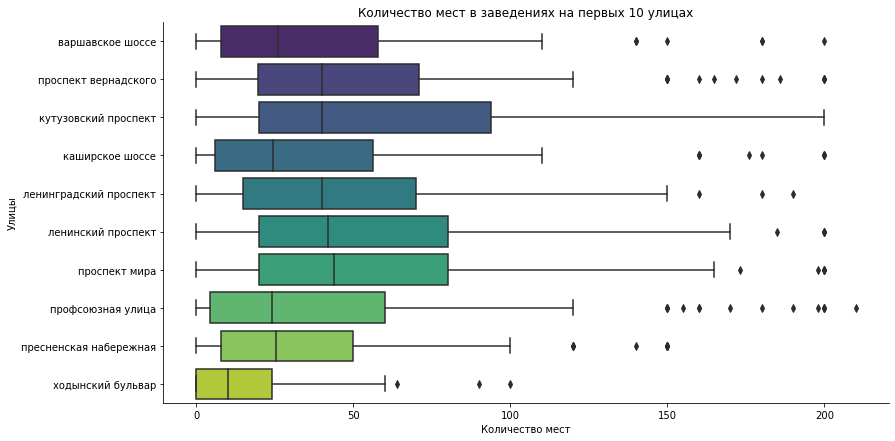

In [45]:
plt.figure(figsize=(13, 7))
plt.title('Количество мест в заведениях на первых 10 улицах')
ax = sns.boxplot(data = top_10_streets_data, x = 'number', y = 'street', palette="viridis", orient = 'h')
ax.set_xlabel('Количество мест')
ax.set_ylabel('Улицы')
sns.despine() 

<b>Вывод: </b> улицы можно разбить на группы по распределию и медианному количеству. 

 - Все проспекты имеют медиану около 40 мест, также у проспектов среднее отклонение от медианы существенно выше, чем у остальных.
 - Второй группой можно выделить шоссе, улицу и набережную: их медианное количество мест находится ближе к 25 и отклонение ниже.
 - На Ходынском бульваре в среднем мест меньше всего. Это короткая улица, где большая доля заведений пользуется общими местами.

## Выводы:

 - Наибольшую долю всех предприятий занимают кафе, их суммарное число выше двух следующих за ними категорий. На 2-ом и 3-ем местах рестораны и столовые соответственно. Меньше всего закусочных и отделов кулинарии в магазинах.
 - Основная масса заведений(около 80%) не относятся к сетевым.
 - Максимальная доля сетевых заведений в предприятиях быстрого обслуживания (41.13%) и отделах кулинарии магазинов (28.57%). Реже всего сетевую к сетям принадлежат столовые, буфеты и бары.
 - У крупных сетей среднее количество мест обычно не больше 100. Возможна определенная обратная связь между размером сети и количеством мест в ее заведениях.
 - В среднем, количество мест в столовых и ресторанах существенно выше, чем в остальных типах заведений. При этом, количество мест в столовых распределено относительно равномерно, поэтому доля заведений с количеством мест выше 150 немного ниже 25%.
 - Закусочные, кафетерии и отделы кулинарии в магазинах стандартно имеют мест меньше остальных.
 - У закусочных, предприятий быстрого питания и отделов кулинарии сетевые заведения чаще имеют больше мест, по сравнению с не сетевыми.
 - Улицы с наибольшим количеством объектов общественного питания - длинные проспекты и шоссе в Южной половине города. Такие улицы чаще встречаются в южных районах, находящихся между центральными и окраинными районами.
 - Улицы, с одним объектом общественного питания чаще всего встречаются в центральных районах Москвы. Вероятно, в остальных районах маленькие улицы реже кажутся удачным местом.
 - Среди улиц с максимальным числом заведений можно выделить проспекты в отдельную группу: в среднем, заведения на них имеют около 40 мест, но разброс значений большой.
 - На шоссе, улицах и набережных количество мест чаще около 25.